In [1]:
import pandas as pd 
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, BisectingKMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

import optuna

### Carregar dados

In [2]:
df_laptops = pd.read_csv('./datasets/data.csv')

In [3]:
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

In [4]:
df_laptops.head(10)

,index,brand,model,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty
0,1,tecno,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,287.72,63,intel,core i3,2,4,8,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
1,2,tecno,Tecno Megabook T1 Laptop (11th Gen Core i7/ 16...,431.64,67,intel,core i7,4,8,16,SSD,1024,intel,integrated,False,15.6,1920,1080,windows,1
2,3,hp,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,612.86,73,amd,ryzen 5,6,12,8,SSD,512,amd,dedicated,False,15.6,1920,1080,windows,1
3,4,acer,Acer Extensa EX214-53 Laptop (12th Gen Core i5...,479.62,62,intel,core i5,12,16,8,SSD,512,intel,integrated,False,14.0,1920,1080,windows,1
4,5,lenovo,Lenovo V15 82KDA01BIH Laptop (AMD Ryzen 3 5300...,342.77,62,amd,ryzen 3,4,8,8,SSD,512,amd,integrated,False,15.6,1920,1080,windows,1
5,6,apple,Apple MacBook Air 2020 MGND3HN Laptop (Apple M...,851.41,45,apple,m1,8,8,8,SSD,256,apple,apple,False,13.3,2560,1600,mac,1
6,7,infinix,Infinix INBook Y2 Plus Laptop (11th Gen Core i...,419.65,56,intel,core i5,4,8,16,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
7,8,asus,Asus TUF Gaming F15 FX506HF-HN024W Gaming Lapt...,599.55,70,intel,core i5,6,12,8,SSD,512,nvidia,dedicated,False,15.6,1920,1080,windows,1
8,9,hp,HP 15s-fq5007TU Laptop (12th Gen Core i3/ 8GB/...,443.64,60,intel,core i3,6,8,8,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
9,10,infinix,Infinix Zerobook 2023 Laptop (13th Gen Core i9...,719.48,71,intel,core i9,14,20,32,SSD,1024,intel,integrated,False,15.6,1920,1080,windows,1


### EDA

In [5]:
# Estatiscticas das variaveis
df_laptops.describe()

,index,price,rating,num_cores,num_threads,ram_memory,primary_storage_capacity,display_size,resolution_width,resolution_height
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,505.860747,926.687487,63.931382,8.128153,12.191726,13.047427,610.938446,15.171241,2003.503532,1181.227043
std,287.899458,688.239764,10.190575,4.215499,5.585115,5.591188,266.927666,0.938089,361.965292,263.884019
min,1.000000,117.540000,24.000000,2.000000,0.000000,2.000000,32.000000,10.100000,1080.000000,768.000000
25%,258.500000,522.850000,58.000000,6.000000,8.000000,8.000000,512.000000,14.000000,1920.000000,1080.000000
50%,507.000000,742.390000,64.000000,8.000000,12.000000,16.000000,512.000000,15.600000,1920.000000,1080.000000
75%,754.500000,1070.350000,71.000000,10.000000,16.000000,16.000000,512.000000,15.600000,1920.000000,1200.000000
max,1002.000000,5450.880000,89.000000,24.000000,32.000000,36.000000,2048.000000,18.000000,3840.000000,2560.000000


In [6]:
#checar variavel year of warranty
df_laptops['year_of_warranty'].unique()

array(['1', '2', 'No information', '3'], dtype=object)

In [7]:
#substituir no information por 0
df_laptops.loc[df_laptops['year_of_warranty'] == 'No information'] = 1
df_laptops['year_of_warranty'] = df_laptops['year_of_warranty'].astype(int)

C:\Users\ThayanneCristinedaSi\AppData\Local\Temp\ipykernel_26936\1631204978.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_laptops.loc[df_laptops['year_of_warranty'] == 'No information'] = 1


In [8]:
#transforma boleana em int (is touch screen)
df_laptops['is_touch_screen'] = df_laptops['is_touch_screen'].astype(int)

In [9]:
#distribuição da variavel brand
percentual_brand = df_laptops.value_counts('brand') / len(df_laptops) * 100
px.bar(percentual_brand, color=percentual_brand.index)

In [10]:
#distribuição da bvariavel processor_brand
#distribuição da variavel brand
percentual_brand = df_laptops.value_counts('processor_brand') / len(df_laptops) * 100
px.bar(percentual_brand, color=percentual_brand.index)

<Axes: xlabel='price', ylabel='Count'>

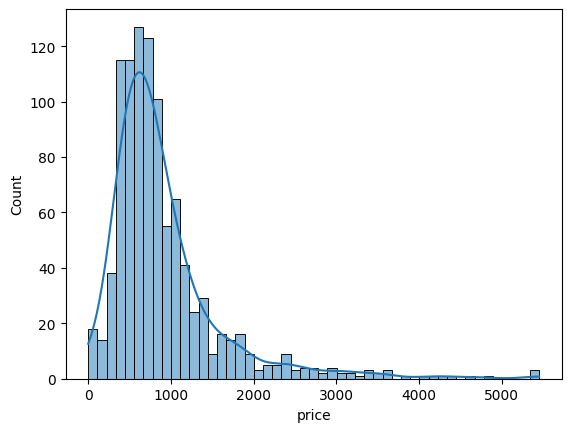

In [11]:
#distribuição da variavel price
sns.histplot(df_laptops['price'], kde=True)

<Axes: xlabel='rating', ylabel='Count'>

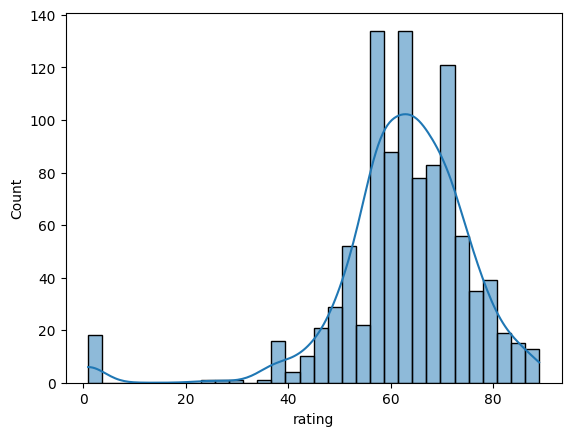

In [12]:
#distribuição da variavel rating
sns.histplot(df_laptops['rating'], kde=True)

In [13]:
#distribuição por brand e price
px.box(df_laptops, x='price', y='brand', color='brand', orientation='h')

In [14]:
#distribuição por brand e rating
px.box(df_laptops, x='rating', y='brand', color='brand', orientation='h')

In [15]:
#scaterplot de price e rating
px.scatter(df_laptops, x='price', y='rating', color='brand')

### Treinar modelos hierarquicos 

In [16]:
#Selecionar as colunas para clusterização
X = df_laptops.copy()

#remover colunas desnecessarias
X.drop(columns=['index', 'model'], axis=1, inplace=True)


In [17]:
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

In [18]:
#separarndo variaveis numericas e categoricas
numeric_features = ['price', 'rating', 'num_cores', 'num_threads', 'ram_memory', 'primary_storage_capacity', 'display_size', 'resolution_width', 'resolution_height']
categorical_features = ['brand', 'processor_brand', 'gpu_brand', 'gpu_type', 'os']


In [19]:
#definir transformações
numeric_transformer = StandardScaler()
categorical_tranforme = OneHotEncoder()

In [20]:
#criar processador de transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', numeric_transformer, numeric_features)
    ]
)

In [21]:
#transformar os dados
X_transformed = preprocessor.fit_transform(X)

In [22]:
X_transformed

array([[-0.89420835,  0.01963648, -1.40004022, ...,  0.32554941,
        -0.11125981, -0.26776121],
       [-0.68782004,  0.3236951 , -0.93531409, ...,  0.32554941,
        -0.11125981, -0.26776121],
       [-0.42794171,  0.77978304, -0.47058796, ...,  0.32554941,
        -0.11125981, -0.26776121],
       ...,
       [-0.53302881, -0.28442214, -0.93531409, ...,  0.32554941,
        -0.11125981, -0.26776121],
       [-0.13744643,  0.39970976, -0.47058796, ..., -0.43467319,
         1.31476515,  1.42806639],
       [-0.94580543, -1.95674457, -1.40004022, ...,  0.32554941,
        -1.34566266, -1.28525778]])

In [23]:
def hierarchical_aglomerative_objetive(trial):
    #definir hiperparams
    n_clusters = trial.suggest_int('n_clusters', 10, 150 )
    #linkage é o criterio de distancia entre dois conjuntos
    #ward usa variancia, average usa media, complete maxima e single minima
    linkage = trial.suggest_categorical('linkage',['ward', 'average', 'complete', 'single'])
    #instanciar o modelo
    hierarchical_model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

    #treinar o modelo e ja executar a cluterizacao
    y = hierarchical_model.fit_predict(X_transformed)

    #calcular o silhouette score
    silhouette_avg = silhouette_score(X_transformed, y)
    return silhouette_avg

In [24]:
#criar um estudo no optuna
search_space_ag = {'n_clusters': range(10, 150), 'linkage': ['ward', 'average', 'complete', 'single']}
sampler_ag = optuna.samplers.GridSampler(search_space=search_space_ag)
estudo_ag = optuna.create_study(direction='maximize', sampler=sampler_ag)

[I 2025-06-05 15:03:58,041] A new study created in memory with name: no-name-93ef06d6-ef8b-4238-afab-e5a35fdf39be


In [25]:
# Executar estudo do optuna para aglomerações
estudo_ag.optimize(hierarchical_aglomerative_objetive, n_trials=600)

[I 2025-06-05 15:03:58,076] Trial 0 finished with value: 0.04181476776106834 and parameters: {'n_clusters': 94, 'linkage': 'single'}. Best is trial 0 with value: 0.04181476776106834.
[I 2025-06-05 15:03:58,107] Trial 1 finished with value: 0.3222651745005819 and parameters: {'n_clusters': 138, 'linkage': 'complete'}. Best is trial 1 with value: 0.3222651745005819.
[I 2025-06-05 15:03:58,136] Trial 2 finished with value: 0.3337025087810924 and parameters: {'n_clusters': 76, 'linkage': 'ward'}. Best is trial 2 with value: 0.3337025087810924.
[I 2025-06-05 15:03:58,163] Trial 3 finished with value: 0.25248509526832114 and parameters: {'n_clusters': 68, 'linkage': 'complete'}. Best is trial 2 with value: 0.3337025087810924.
[I 2025-06-05 15:03:58,193] Trial 4 finished with value: 0.27848934860521396 and parameters: {'n_clusters': 103, 'linkage': 'average'}. Best is trial 2 with value: 0.3337025087810924.
[I 2025-06-05 15:03:58,219] Trial 5 finished with value: 0.2753430348993639 and parame

In [26]:
#mostrar melhor configuração do optuna
best_params_ag = estudo_ag.best_params

print(f'clusters = {best_params_ag['n_clusters']}')
print(f'linkage = {best_params_ag['linkage']}')

clusters = 11
linkage = average


In [27]:
def hierarchical_divisive_objetive(trial):
    #definir hiperparams
    n_clusters = trial.suggest_int('n_clusters', 10, 150 )
    
    #instanciar o modelo
    hierarchical_model = BisectingKMeans(n_clusters=n_clusters)

    #treinar o modelo e ja executar a cluterizacao
    y = hierarchical_model.fit_predict(X_transformed)

    #calcular o silhouette score
    silhouette_avg = silhouette_score(X_transformed, y)
    return silhouette_avg

In [28]:
#criar um estudo no optuna
search_space_di = {'n_clusters': range(10, 150)}
sampler_di = optuna.samplers.GridSampler(search_space=search_space_di)
estudo_di = optuna.create_study(direction='maximize', sampler=sampler_di)

[I 2025-06-05 15:05:07,870] A new study created in memory with name: no-name-214ec6f5-7f73-42af-86a1-e80a491bcd23


In [29]:
# Executar estudo do optuna para aglomerações
estudo_di.optimize(hierarchical_divisive_objetive, n_trials=200)

[I 2025-06-05 15:05:13,342] Trial 0 finished with value: 0.24116539193206807 and parameters: {'n_clusters': 55}. Best is trial 0 with value: 0.24116539193206807.
[I 2025-06-05 15:05:13,688] Trial 1 finished with value: 0.2614064011907857 and parameters: {'n_clusters': 69}. Best is trial 1 with value: 0.2614064011907857.
[I 2025-06-05 15:05:13,793] Trial 2 finished with value: 0.25961154679194215 and parameters: {'n_clusters': 17}. Best is trial 1 with value: 0.2614064011907857.
[I 2025-06-05 15:05:14,073] Trial 3 finished with value: 0.25219907407170433 and parameters: {'n_clusters': 60}. Best is trial 1 with value: 0.2614064011907857.
[I 2025-06-05 15:05:14,539] Trial 4 finished with value: 0.2850877953022063 and parameters: {'n_clusters': 102}. Best is trial 4 with value: 0.2850877953022063.
[I 2025-06-05 15:05:14,724] Trial 5 finished with value: 0.21967622903514272 and parameters: {'n_clusters': 37}. Best is trial 4 with value: 0.2850877953022063.
[I 2025-06-05 15:05:15,456] Trial 

In [30]:
#mostrar melhor configuração do optuna
best_params_di = estudo_di.best_params

print(f'clusters = {best_params_di['n_clusters']}')

clusters = 148


In [31]:
# criar modelo com melhor configuraçõa (aglomerative)
best_model = AgglomerativeClustering(
    n_clusters=best_params_ag['n_clusters'],
    linkage=best_params_ag['linkage']
)

In [32]:
#treinar modelo
best_model.fit(X_transformed)

AgglomerativeClustering(linkage='average', n_clusters=11)

In [33]:
#verificar silhouette score
best_score = silhouette_score(X_transformed, best_model.labels_)
best_score

0.4132380142081687

In [34]:
#criar coluna com cluster escolhido no dataframe original
df_laptops['cluster'] = best_model.labels_

In [35]:
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

### Visualizar resultados

In [36]:
#mostrar chart com trials do optuna
fig = optuna.visualization.plot_optimization_history(estudo_ag)
fig.show()

In [37]:
# mostrar o dendrogram treinar com scipy
modelo_de = linkage(X_transformed, method=best_params_ag['linkage'], optimal_ordering=True)


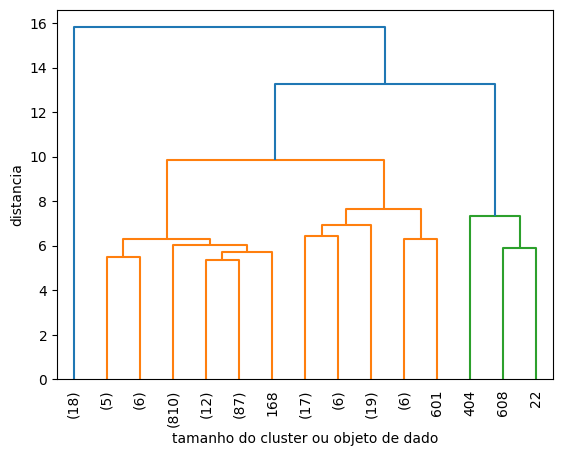

In [38]:
plt.Figure(figsize=(10,7))
dendrogram(modelo_de, truncate_mode='lastp', p=15, leaf_rotation=90, leaf_font_size=10)
plt.xlabel('tamanho do cluster ou objeto de dado')
plt.ylabel('distancia')
plt.show()

In [39]:
#cortar o dendograma
clusters_de_scipy = cut_tree(modelo_de, height=32)
len(np.unique(clusters_de_scipy))

1

In [40]:
#cruzamento entre brand e price apresentando os clusters
px.scatter(df_laptops, x='brand', y='price', color='cluster')

In [41]:
#cruzamento entre brand e price apresentando os clusters
px.scatter(df_laptops, x='brand', y='rating', color='cluster')

In [42]:
#cruzamento entre brand e price apresentando os clusters
px.scatter(df_laptops, x='cluster', y='rating', color='brand')

In [43]:
#distribuição da variavel cluster
qtde_cluster = df_laptops.value_counts('cluster')
px.bar(qtde_cluster, color=qtde_cluster.index)

### Salvar modelo

In [44]:
import joblib

In [45]:
joblib.dump(best_model, './modelo_laptops.pkl')

joblib.dump(preprocessor, './preprocessor.pkl')

['./preprocessor.pkl']

In [46]:
# salvar csv atualizado com dado de cluster
df_laptops.to_csv('./datasets/clusterizacao_lapstops.csv', index=False)